Raw Image: shape=(4418, 4418), dtype=uint16, min=0, max=9538
Reference Image: shape=(4418, 4418, 3), dtype=uint8


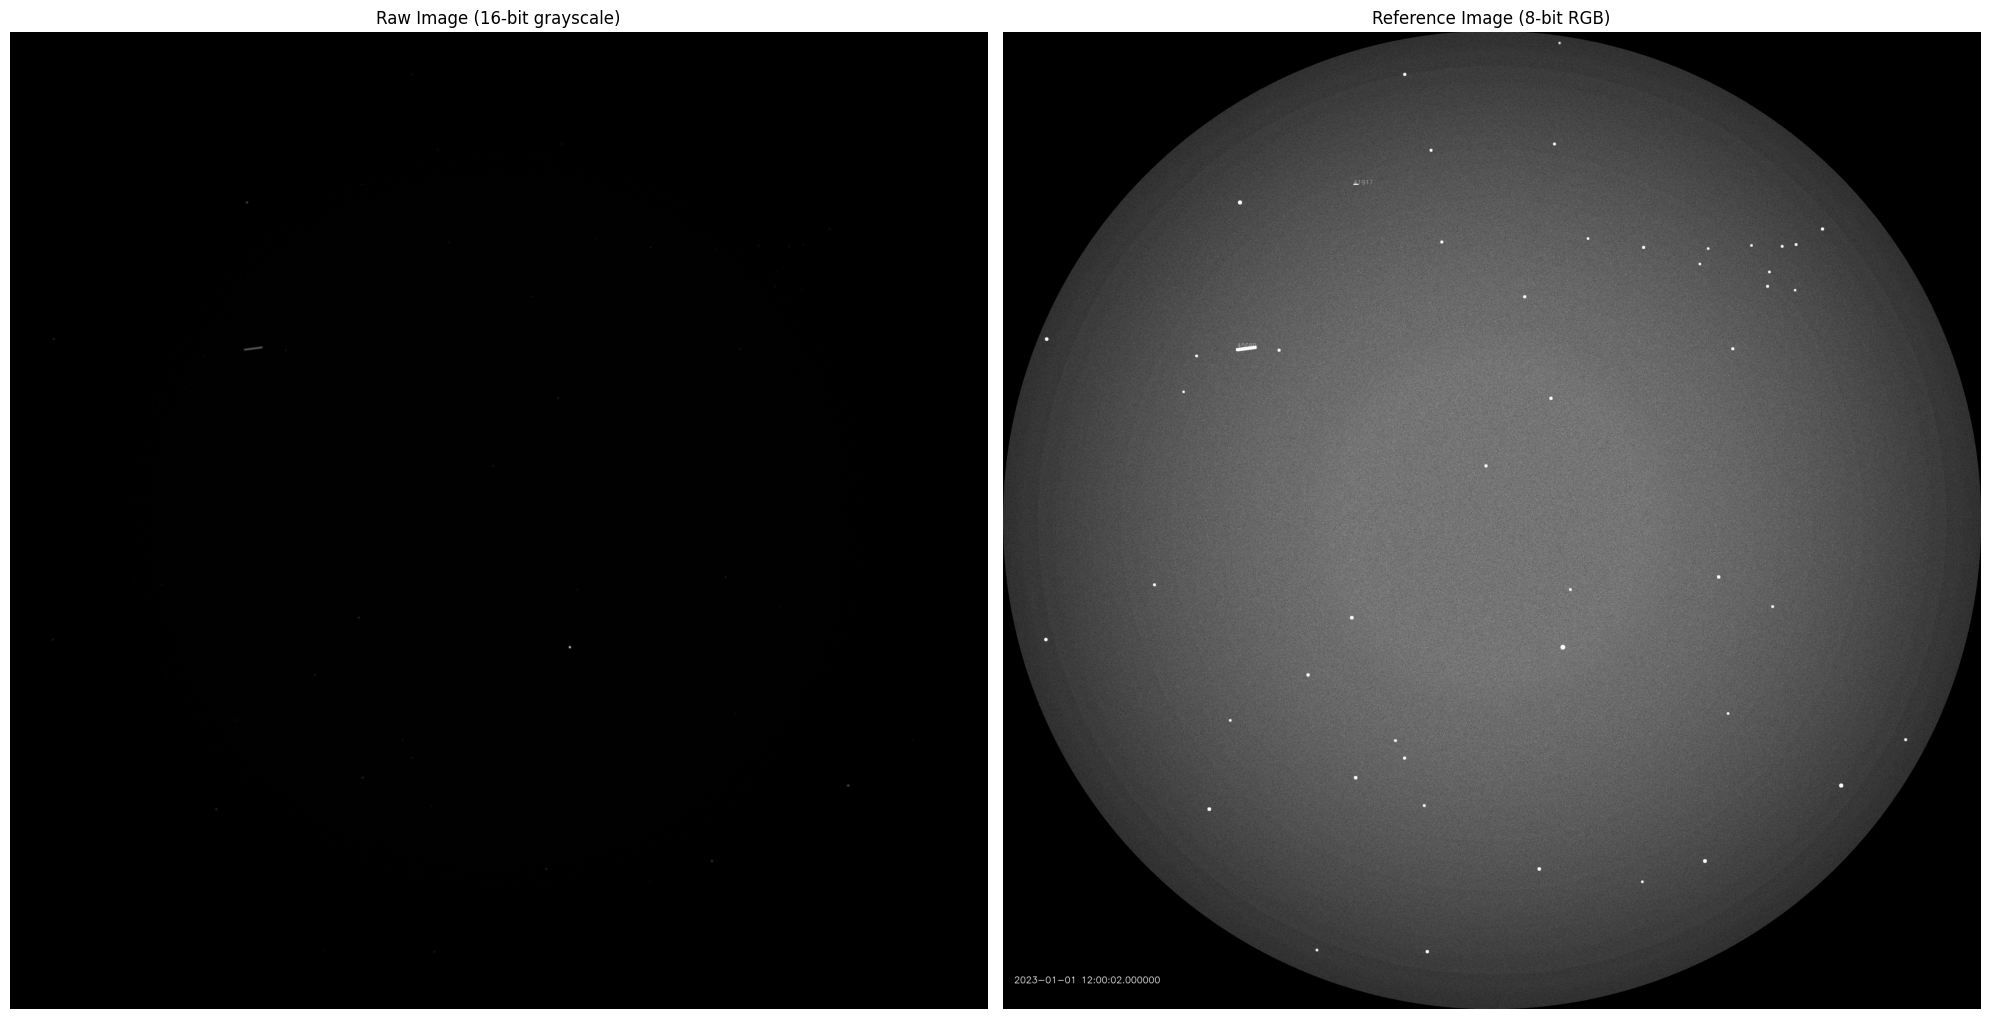

In [2]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Set your base folder
base_path = "Datasets"
raw_path = os.path.join(base_path, "Raw_Images")
ref_path = os.path.join(base_path, "Reference_Images")

# List image files
raw_images = sorted(glob(os.path.join(raw_path, "*.tiff")))
ref_images = sorted(glob(os.path.join(ref_path, "*.jpeg")))

# Load first image pair
raw_img = cv2.imread(raw_images[0], cv2.IMREAD_UNCHANGED)  # 16-bit grayscale
ref_img = cv2.imread(ref_images[0])                         # 8-bit RGB
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)          # Convert to RGB for matplotlib

# Info
print(f"Raw Image: shape={raw_img.shape}, dtype={raw_img.dtype}, min={raw_img.min()}, max={raw_img.max()}")
print(f"Reference Image: shape={ref_img.shape}, dtype={ref_img.dtype}")

# Visualize side-by-side
plt.figure(figsize=(20  , 20))
plt.subplot(1, 2, 1)
plt.imshow(raw_img, cmap='gray')
plt.title("Raw Image (16-bit grayscale)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ref_img)
plt.title("Reference Image (8-bit RGB)")
plt.axis('off')
plt.tight_layout()
plt.show()


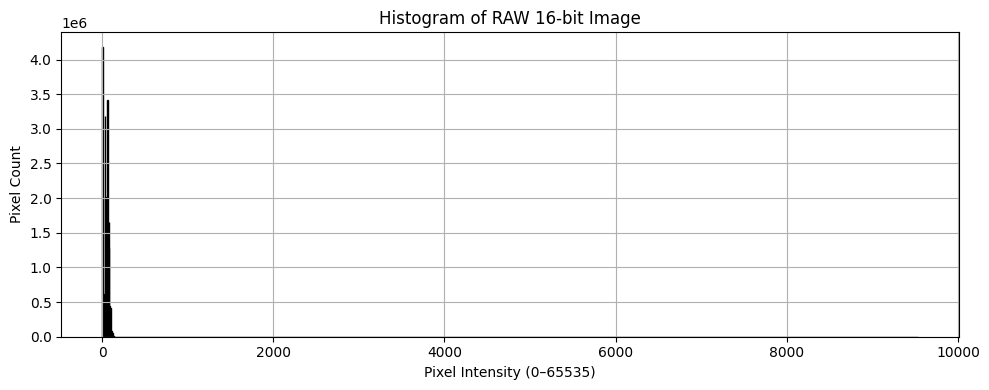

In [4]:
# Flatten the 2D image to 1D for histogram
plt.figure(figsize=(10, 4))
plt.hist(raw_img.ravel(), bins=1000, color='skyblue', edgecolor='black')
plt.title("Histogram of RAW 16-bit Image")
plt.xlabel("Pixel Intensity (0–65535)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()


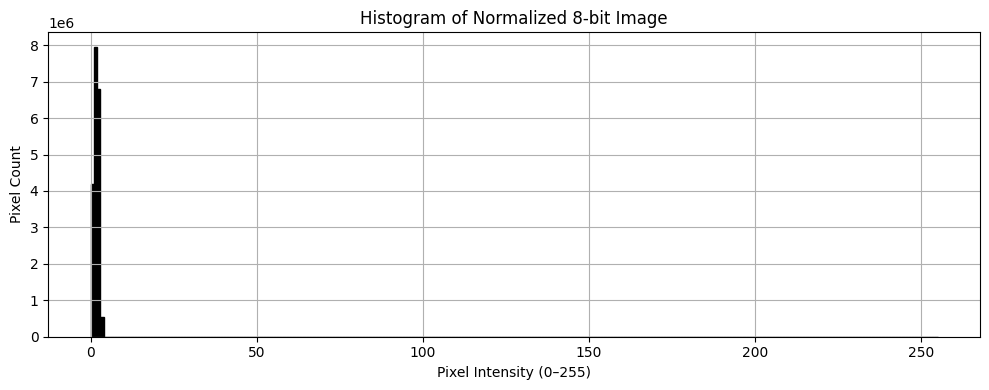

In [7]:
# Normalize to 0–255 and convert to 8-bit
raw_img_norm = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX)
raw_img_8bit = raw_img_norm.astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.hist(raw_img_8bit.ravel(), bins=256, color='black', edgecolor='black')
plt.title("Histogram of Normalized 8-bit Image")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()


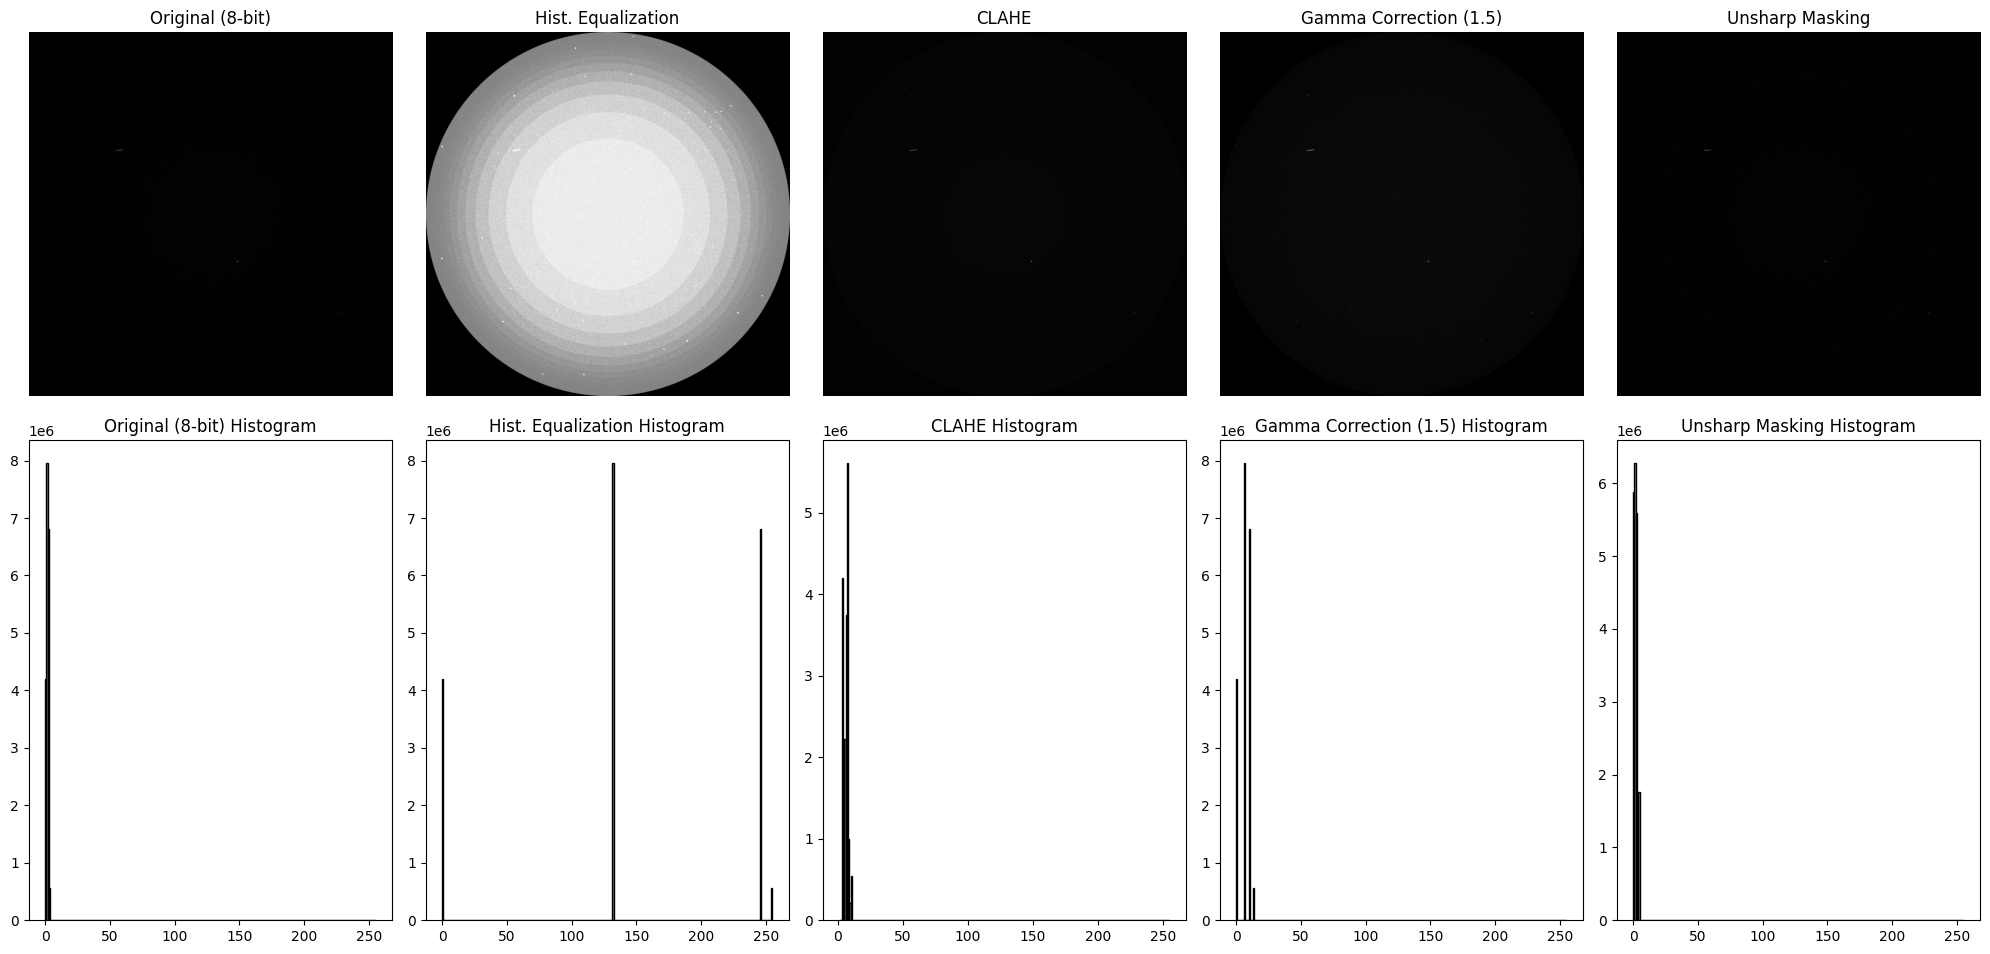

In [9]:
def apply_hist_equalization(img):
    return cv2.equalizeHist(img)

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def apply_gamma_correction(img, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def apply_unsharp_mask(img, blur_ksize=(9, 9), amount=1.5):
    blurred = cv2.GaussianBlur(img, blur_ksize, 0)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return sharpened
# Apply all enhancements
he_img = apply_hist_equalization(raw_img_8bit)
clahe_img = apply_clahe(raw_img_8bit)
gamma_img = apply_gamma_correction(raw_img_8bit, gamma=1.5)
sharp_img = apply_unsharp_mask(raw_img_8bit)
titles = ['Original (8-bit)', 'Hist. Equalization', 'CLAHE', 'Gamma Correction (1.5)', 'Unsharp Masking']
images = [raw_img_8bit, he_img, clahe_img, gamma_img, sharp_img]

plt.figure(figsize=(20, 10))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.hist(img.ravel(), bins=256, color='gray', edgecolor='black')
    plt.title(f'{title} Histogram')
    plt.tight_layout()
plt.show()


In [21]:
# Apply threshold at intensity 15 on CLAHE-enhanced image
_, thresh_img = cv2.threshold(clahe_img, 10, 255, cv2.THRESH_BINARY)

# Show the result



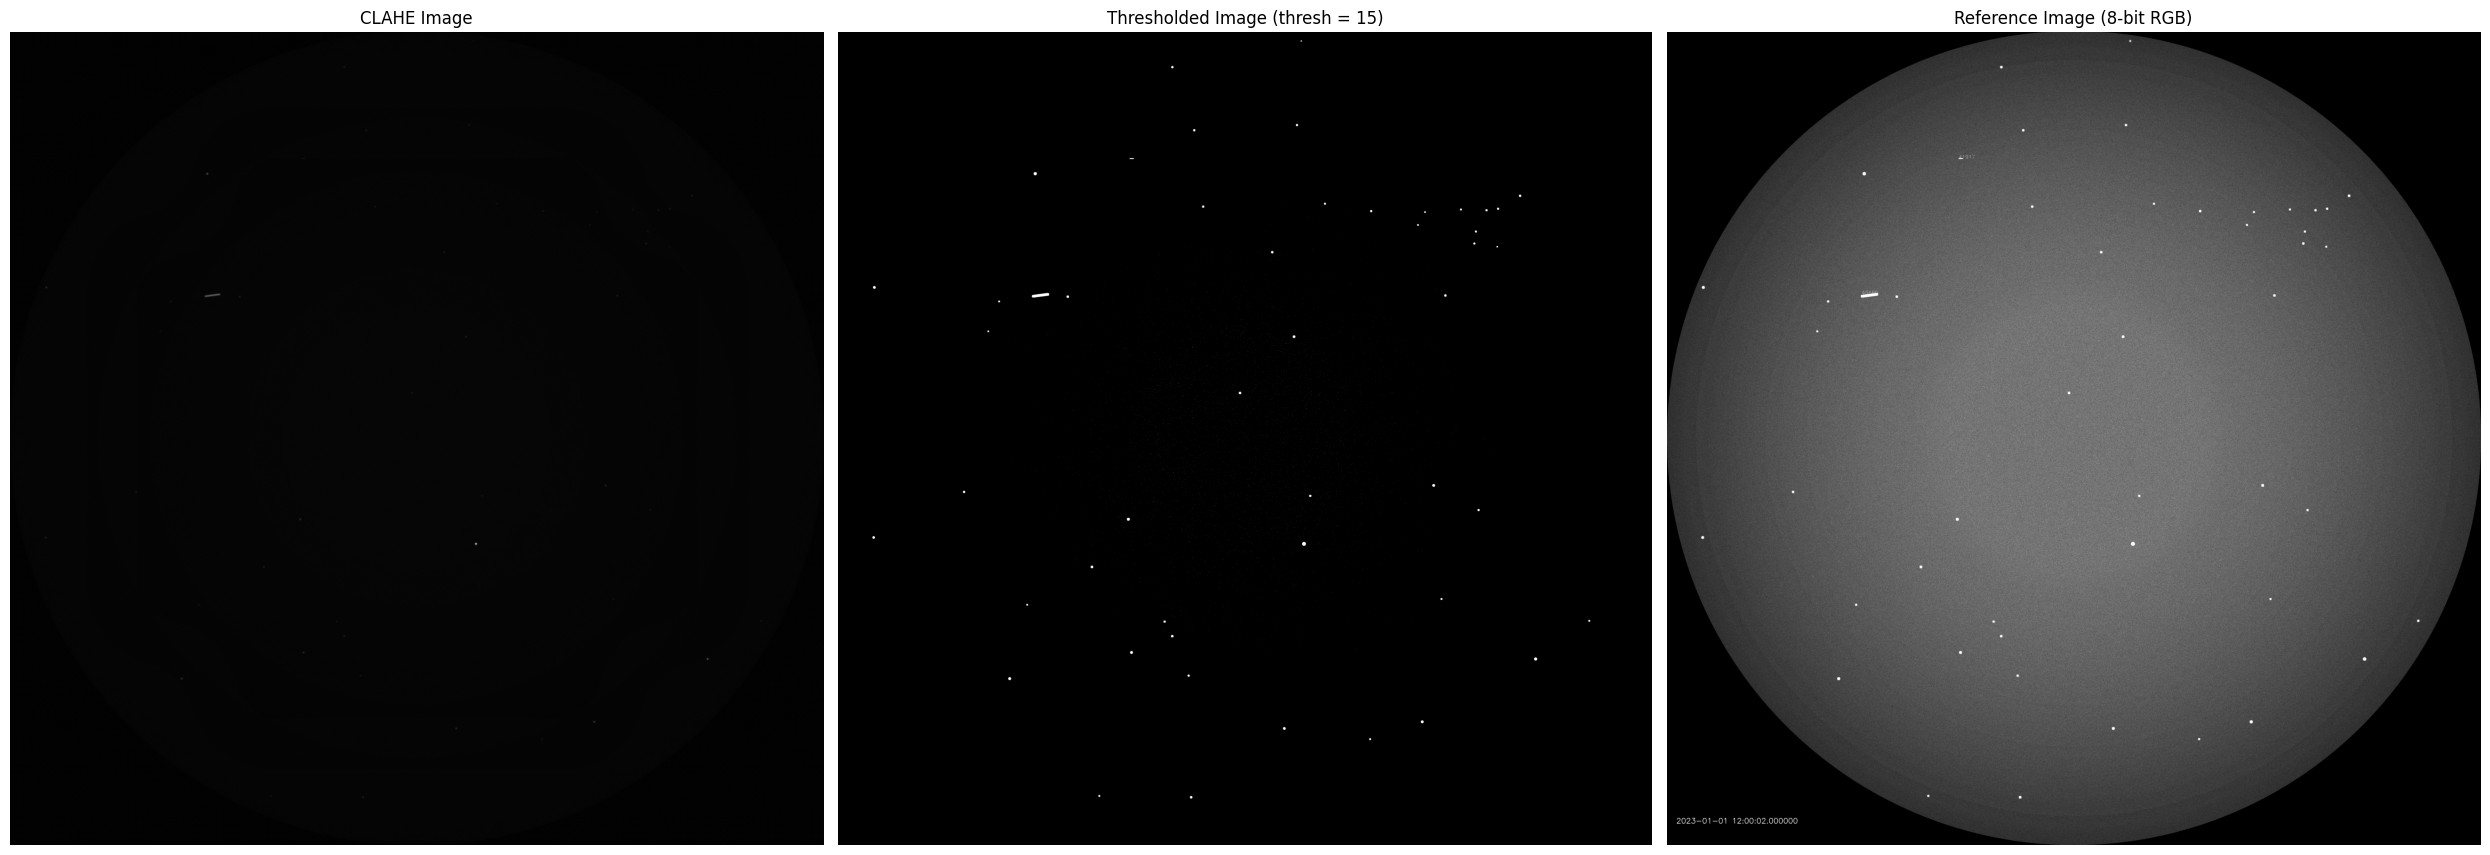

In [22]:
plt.figure(figsize=(25  , 25))

plt.subplot(1, 3, 1)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image (thresh = 15)')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(ref_img)
plt.title("Reference Image (8-bit RGB)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
def gabor_filter(kernel_size=21, sigma=5.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    """
    Generate Gabor Kernel based on the provided parameters
    :param kernel_size: Size of the kernel
    :param sigma: Standard deviation of the Gaussian envelope
    :param theta: Orientation of the filter (angle)
    :param lambd: Wavelength of the sinusoidal factor
    :param gamma: Spatial aspect ratio (ellipticity)
    :param psi: Phase offset
    :return: Gabor filter kernel
    """
    # Create the Gabor kernel using OpenCV function
    gabor_kernel = cv2.getGaborKernel(
        (kernel_size, kernel_size),    # Kernel size
        sigma,                         # Sigma (Gaussian envelope)
        theta,                         # Theta (Orientation)
        lambd,                         # Lambda (Wavelength)
        gamma,                         # Gamma (Aspect ratio)
        psi                            # Psi (Phase offset)
    )
    return gabor_kernel



In [31]:
def apply_gabor_filter(img, kernel_size=21, sigma=5.0, lambd=40.0, gamma=0.5, psi=0):
    theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different orientations (0°, 45°, 90°, 135°)
    filtered_images = []

    for theta in theta_values:
        kernel = gabor_filter(kernel_size, sigma, theta, lambd, gamma, psi)
        filtered_image = cv2.filter2D(img, cv2.CV_32F, kernel)
        filtered_images.append(filtered_image)
    
    return filtered_images



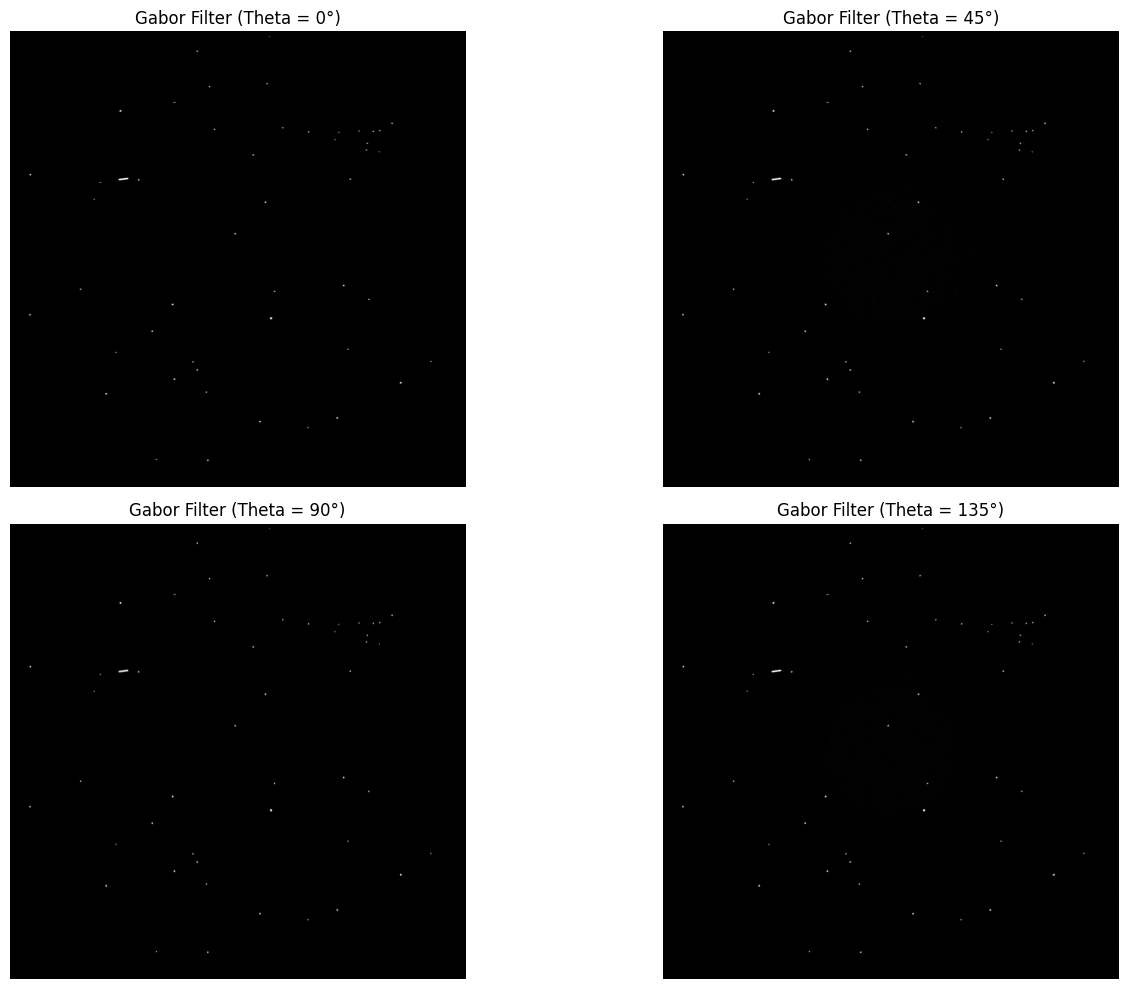

In [36]:
# Apply the Gabor filter to the thresholded image
filtered_images = apply_gabor_filter(thresh_img, kernel_size=21, sigma=5.0, lambd=40.0, gamma=5, psi=0)

# Plot the results (filtered images for each orientation)
plt.figure(figsize=(15, 10))
for i, filtered_img in enumerate(filtered_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(filtered_img, cmap='gray')
    plt.title(f'Gabor Filter (Theta = {i * 45}°)')
    plt.axis('off')

plt.tight_layout()
plt.show()
